# Final Project

## Feature Prototype

### Project Idea 1: Deep Learning on a public dataset



In [1]:
# Importing Tensor flow and checking that the GPU is Recognized

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


# Load Data

In [2]:
# Importing Library to load the Dataset
from scipy.io import loadmat

# Change this names !!

train_raw = loadmat('../data/mat/train_32x32.mat')  # Train Set
test_raw = loadmat('../data/mat/test_32x32.mat')    # Test Set
extra_raw = loadmat('../data/mat/extra_32x32.mat')  # Extra Set

Below, I am splitting up the dataset into training data and training labels

In [3]:
import numpy as np

# Training Set & Labels
train_data = train_raw['X']
train_labels = train_raw['y']

# Extra Dataset & Labels
extra_data = extra_raw['X']
extra_labels = extra_raw['y']

# Test Data & Labels
test_data = test_raw['X']
test_labels = test_raw['y']

In [4]:
# del train_raw, test_raw, extra_raw

Below, I am checking the shape of each of the data and labels sets.

In [5]:
print('Training Data:', train_data.shape, 'Training Labels:', train_labels.shape)
print('Extra Data:', extra_data.shape, 'Extra Lables:', extra_labels.shape)
print('Test Data:', test_data.shape, 'Test Lables:', test_labels.shape)


Training Data: (32, 32, 3, 73257) Training Labels: (73257, 1)
Extra Data: (32, 32, 3, 531131) Extra Lables: (531131, 1)
Test Data: (32, 32, 3, 26032) Test Lables: (26032, 1)


# Exploratory Analysis

Below, A function to plot the training image samples.

In [6]:
# Adapted From https://www.tensorflow.org/tutorials/load_data/images

# Import the matplotlib library for visualization
import matplotlib.pyplot as plt

def plot_sample_images(data, labels):

    # Create a new figure with a specific size of 10x10
    plt.figure(figsize=(10, 10))

    # Loop over the first 9 images in the dataset
    for i in range(9):
        
        # Create a subplot in a 3x3 grid
        ax = plt.subplot(3, 3, i + 1)
        
        # Display the i-th image from the 'train_data'    
        plt.imshow(data[:, :, :, i])
        
        # Set the title of the subplot to the corresponding label in 'train_labels'
        plt.title(labels[i])
        
        # Turn off the axis to remove ticks and labels for a cleaner display
        plt.axis("off")


Here are the first nine images from the training dataset.

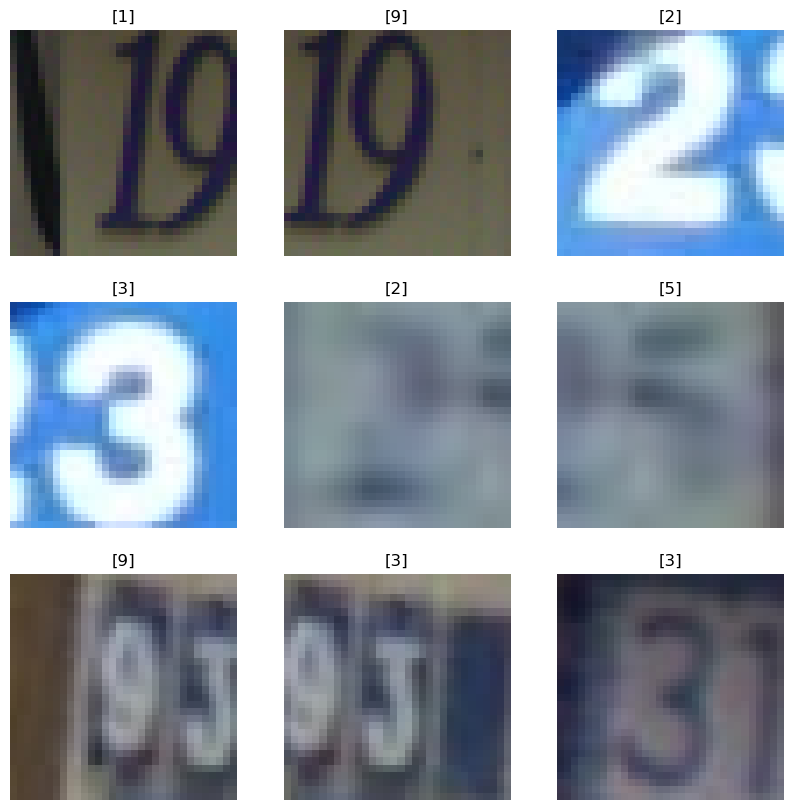

In [7]:
plot_sample_images(train_data, train_labels)

You can see that the 32 x 32 images contain distracting numbers to the side making it a real-world issue to solve.

Below, I am creating a function to display the distribution of the labels in the datasets.

In [8]:
import numpy as np
import seaborn as sns

def label_count_plot(labels, x_axis, y_axis, title, axis=None):
    """
    Creates a bar plot to visualize the count of unique labels in a dataset.

    Parameters:
    -----------
    labels : array-like
        A list, array, or similar structure containing categorical data.
    x_axis : str
        The label for the x-axis of the plot.
    y_axis : str
        The label for the y-axis of the plot.
    title : str
        The title of the bar plot.

    Returns: None
    --------
    """

    # Get unique labels and their counts from the input data
    unqique, counts = np.unique(labels, return_counts=True)

    # Combine the unique labels and their counts into a dictionary
    dict_counts =  dict(zip(unqique, counts))

    # Create a bar plot using Seaborn
    # x-axis: unique labels
    # y-axis: counts of each label
    # Set the axis labels and title of the plot
    sns.barplot(dict_counts, x=dict_counts.keys(), y= dict_counts.values(),
                 ax=axis).set(xlabel=x_axis, ylabel=y_axis, title=title) 


Plotting the datasets Label distributions.

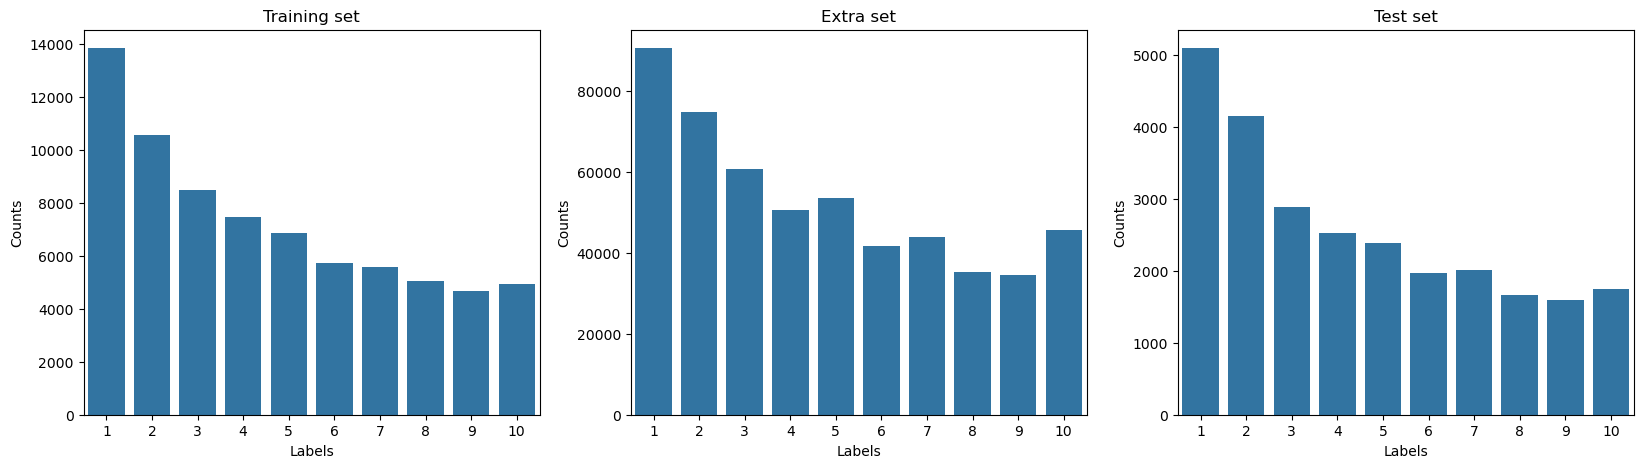

In [9]:
# Create a subplot in a 3x3 grid
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
label_count_plot(train_labels, "Labels", "Counts", "Training set", axis=ax[0])
label_count_plot(extra_labels, "Labels", "Counts", "Extra set", axis=ax[1])
label_count_plot(test_labels, "Labels", "Counts", "Test set", axis=ax[2])

You can see from the plots above that the data is imbalanced. I will have to address this imbalance in order to create an accurate model. All the dataset have more or less the same distribution imbalances.

# Pre-Processing

Here I will pre-process the dataset for training. I will be using the same method as ( Sermanet, Pierre, Chintala, Soumith, and LeCun, Yann ) in their paper 'Convolutional neural networks applied to house numbers digit classification'. 

In [10]:
# Function to create a validation set

def create_validation_set(X, y, num_samples_per_class):

    # Array: Stores the unique classes of label set
    unique_classes = np.unique(y)

    # List: To store chosen indexes                   
    chosen_indexes = []                             
    
    # Loop: iterate through each class
    for cls in unique_classes:                      

        # Array: Store all indexes from a class
        class_indexes = np.where(y == cls)[0]       

        # Array: Randomly select n indices from 'class_indexes'
        chosen_class_indexes = np.random.choice(class_indexes, num_samples_per_class, replace=False)
        # List:  Add each class indices to a list
        chosen_indexes.extend(chosen_class_indexes)

    # Array: Convert list to Numpy Array
    chosen_indexes = np.array(chosen_indexes)

    # Array:  Return the selected samples, label and indexes
    return X[:, :, :, chosen_indexes], y[chosen_indexes], chosen_indexes


## Validation Set
To build a validation set, we select 400 samples per class from the training set and 200 samples per class from the extra set. The remaining digits of the train and extra sets are used for training.

In [11]:
# Creating Validation Function

# Choose 400 samples from the training set for each class.
X_val_train, y_val_train, val_train_indexes = create_validation_set(train_data, train_labels, 400)

# Choose 200 samples from the extra set for each class.
X_val_extra, y_val_extra, val_extra_indexes = create_validation_set(extra_data, extra_labels, 200)

# Merge the two sets' validation samples.
X_val = np.concatenate((X_val_train, X_val_extra), axis=3)  # Combine along the 4th dimension
y_val = np.concatenate((y_val_train, y_val_extra), axis=0)

print('Validation data:', X_val.shape ,'Validation Labels:', y_val.shape)



Validation data: (32, 32, 3, 6000) Validation Labels: (6000, 1)


In [12]:
# del train_data, train_labels, extra_data, extra_labels, X_val_train, X_val_extra, y_val_train, y_val_extra

There are 6000 samples in the dataset.

Below, I am plotting the distribution of the validation set.

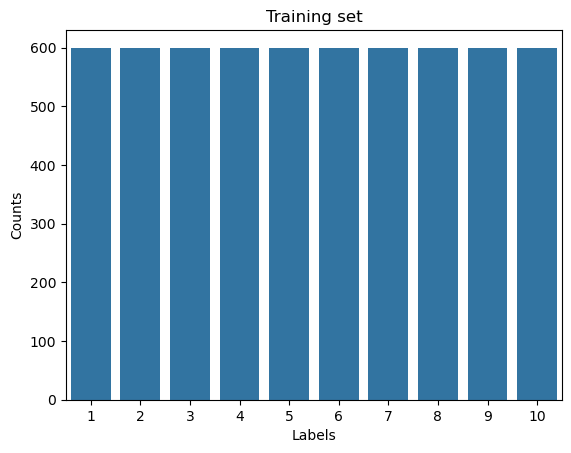

In [13]:
label_count_plot(y_val, "Labels", "Counts", "Training set")

The validation set has an equal distribution.

A function to Shuffle the datasets

In [14]:
def shuffle_dataset(data, labels):

    # Create a random number generator with a fixed seed
    seed = 42
    rng = np.random.default_rng(seed)

    # Generate indexes for the validation set
    shuffle_indexes = np.arange(labels.shape[0])  # Create an array of indexes
    rng.shuffle(shuffle_indexes)  # Shuffle the indexes in-place

    # Reorder X_val and y_val using the shuffled indexes
    shuffled_data = data[:, :, :, shuffle_indexes]
    shuffled_labels = labels[shuffle_indexes]

    return shuffled_data, shuffled_labels

Shuffling the Validation set

In [15]:
X_val, y_val = shuffle_dataset(X_val, y_val)

Plotting 9 sample from the validation set.

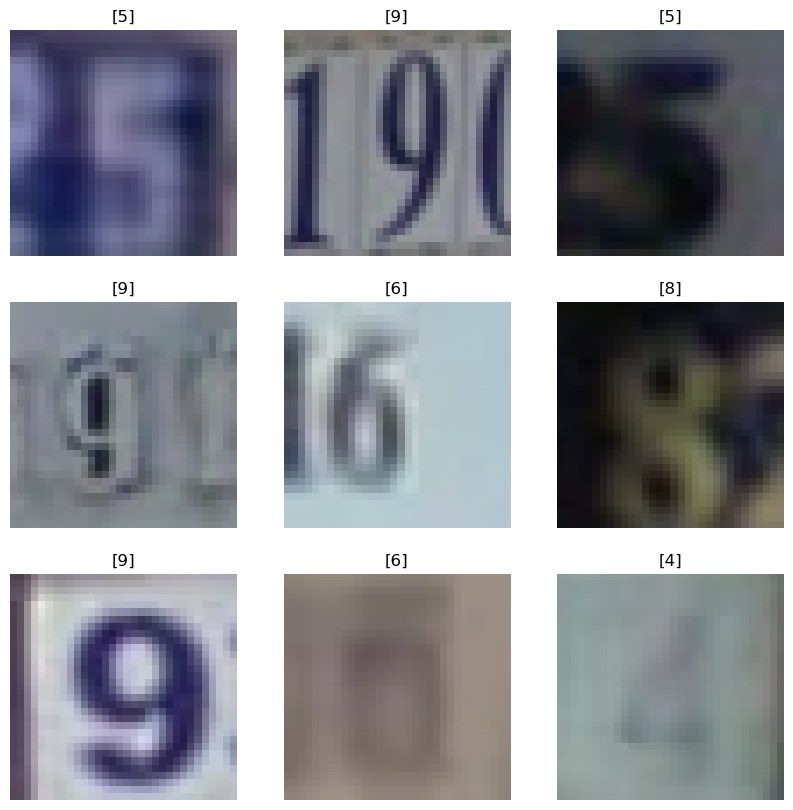

In [16]:
plot_sample_images(X_val, y_val)

## Training Set

Below, I will now remove the validation samples from the training and datasets.

In [17]:
# Remove validation samples from the original training set
X_train_new = np.delete(train_data, val_train_indexes, axis=3)
y_train_new = np.delete(train_labels, val_train_indexes, axis=0)

X_extra_new = np.delete(extra_data, val_extra_indexes, axis=3)
y_extra_new = np.delete(extra_labels, val_extra_indexes, axis=0)




print('===================================================================')
print('Original Shape')
print('Training Data:', train_data.shape, 'Training Labels:', train_labels.shape)
print('Extra Data:', extra_data.shape, 'Extra Lables:', extra_labels.shape)
print('===================================================================')
print('New Shape')
print('Training Data:', X_train_new.shape, 'Training Labels:', y_train_new.shape)
print('Extra Data:', X_extra_new.shape, 'Extra Lables:', y_extra_new.shape)

Original Shape
Training Data: (32, 32, 3, 73257) Training Labels: (73257, 1)
Extra Data: (32, 32, 3, 531131) Extra Lables: (531131, 1)
New Shape
Training Data: (32, 32, 3, 69257) Training Labels: (69257, 1)
Extra Data: (32, 32, 3, 529131) Extra Lables: (529131, 1)


Above, You can see the new datasets size after removing the validation samples

Below, I will now merge the training set and extra set together to create 1 training set.

In [18]:
# Merge the two sets' training data samples.
X_train_merge = np.concatenate((X_train_new, X_extra_new), axis=3)  # Combine along the 4th dimension
y_train_merge = np.concatenate((y_train_new, y_extra_new), axis=0)

print('New training set Data:', X_train_merge.shape, 'New Training set Labels:', y_train_merge.shape)

New training set Data: (32, 32, 3, 598388) New Training set Labels: (598388, 1)


Above, You can see there are now just under 600,00 samples

Shuffling the Merged data set

In [19]:
X_train_merge, y_train_merge = shuffle_dataset(X_train_merge, y_train_merge)

Plotting the new merged dataset samples.

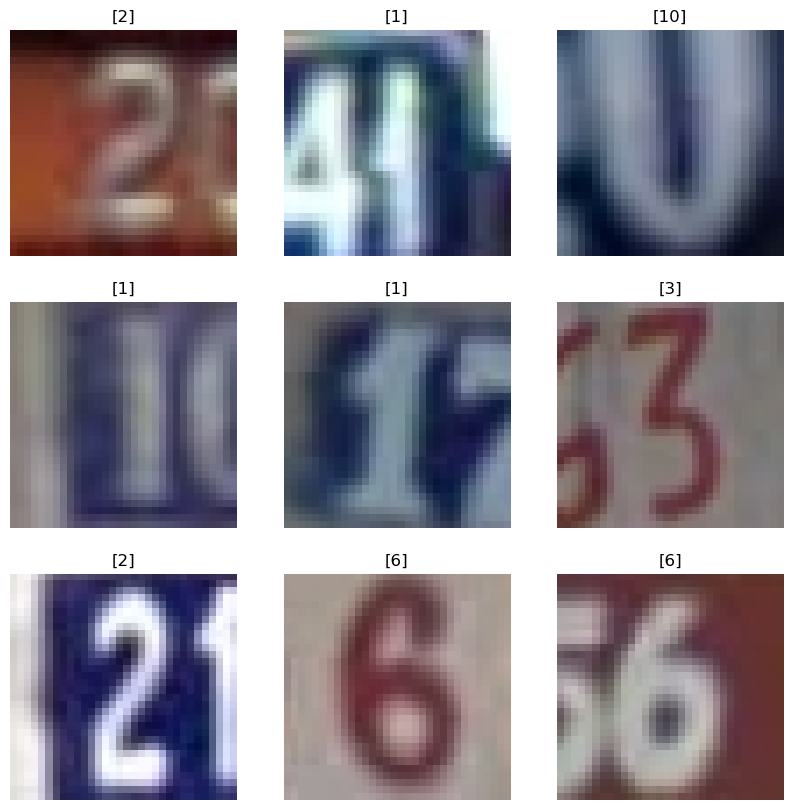

In [20]:
plot_sample_images(X_train_merge, y_train_merge)

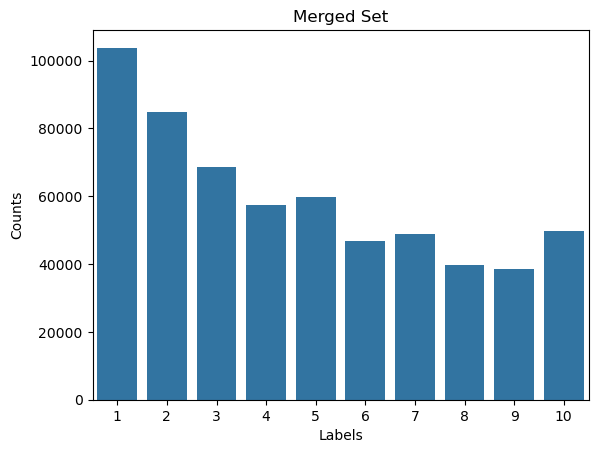

In [21]:
label_count_plot(y_train_merge, "Labels", "Counts", "Merged Set")

## Converting data types and Reshaping

Below, I am converting the training set to float32 and the label set to int32 for better compatibility with the Keras model.

In [22]:
# Convert sets to float32
X_train_float = X_train_merge.astype('float32')     # Training Set Data
X_val_float = X_val.astype('float32')               # Validation Set Data
test_data_float  = test_data.astype('float32')      # Test set Data

y_train_merge = y_train_merge.astype('int32')       # Train set Labels
y_val = y_val.astype('int32')                       # Validation set labels


Below, I am reshaping the data to better match the Tensorflow/Keras standard of (batch_size, height, width, depth)

In [23]:
#Reshape

X_train_reshaped = np.transpose(X_train_float, (3, 0, 1, 2))        # Shape: (32, 32, 3, 598388)
X_val_reshaped = np.transpose(X_val_float, (3, 0, 1, 2))            # Shape: (32, 32, 3, 6000)
test_data_reshaped = np.transpose(test_data_float, (3, 0, 1, 2))    # Shape: (32, 32, 3, 26032)


print("Training data", X_train_reshaped.shape, "Training Labels", y_train_merge.shape )
print("Validation data", X_val_reshaped.shape, "598388, 32, 32, Validation Labels", y_val.shape )
print("Test data", test_data_reshaped.shape, "Test Labels", test_labels.shape)

Training data (598388, 32, 32, 3) Training Labels (598388, 1)
Validation data (6000, 32, 32, 3) 598388, 32, 32, Validation Labels (6000, 1)
Test data (26032, 32, 32, 3) Test Labels (26032, 1)


In [24]:
len(X_train_reshaped)

598388

## Converting Labels to a One hot encoded array

I am using the 'categorical_crossentropy' loss function which expects one hot encoded values. First I will change the way the digit 0 is labelled. At the moment digit 0 is labelled as 10. I will re-label it a 0

In [25]:
# Convert 10 to 0 for all label sets

import numpy as np

# Replace label 10 with 0
y_train_relabelled = np.where(y_train_merge == 10, 0, y_train_merge)
y_val_relabelled = np.where(y_val == 10, 0, y_val)
y_test_relabelled = np.where(test_labels == 10, 0, test_labels)

# Validate the labels
print("Unique values in adjusted y_train_merge:", np.unique(y_train_relabelled ))
print("Unique values in adjusted y_val:", np.unique(y_val_relabelled ))
print("Unique values in adjusted test_labels:", np.unique(y_test_relabelled ))

Unique values in adjusted y_train_merge: [0 1 2 3 4 5 6 7 8 9]
Unique values in adjusted y_val: [0 1 2 3 4 5 6 7 8 9]
Unique values in adjusted test_labels: [0 1 2 3 4 5 6 7 8 9]


One hot encoded the labels below.

In [26]:
stop here !

SyntaxError: invalid syntax (4114787685.py, line 1)

Checking the Images after normalization.

# Data Augmentation

For the Data augmentation I will be flipping and rotating the images. I will not be oversampling the minority classes and I will continue to use the class weights. Because The larger class would have rich variation, the smaller would be many similar images with small affine transforms. I am keen to avoid this keeping diverse samples.

In [27]:
import random

def augment_digits(images, labels):
    flipped_images = []
    flipped_labels = []
    
    for i ,(image, label) in enumerate(zip(images, labels)):
        
        if i % 2 == 0:
            choice = random.choice([0,1,2])

            if label in [6, 9]:
                if choice == 0:
                    flipped_images.append(image)
                    flipped_labels.append(label)  # Keep the label the same
                else: 
                    # Horizontally flip 6 and 9
                    flipped_image = tf.image.flip_left_right(image)  # Horizontal flip
                    flipped_images.append(flipped_image.numpy())
                    flipped_labels.append(label)  # Keep the label the same
            else:
                # Flip other digits both horizontally and vertically
                if choice == 0:                
                    flipped_images.append(image)
                    flipped_labels.append(label)
                elif choice == 1:
                    flipped_image = tf.image.flip_left_right(image)
                    flipped_images.append(flipped_image.numpy())
                    flipped_labels.append(label)
                elif choice == 2:
                    flipped_image = tf.image.random_flip_up_down(image)
                    flipped_images.append(flipped_image.numpy())
                    flipped_labels.append(label)
        else:
            flipped_images.append(image)
            flipped_labels.append(label)  # Keep the label the same
                 
            
    
    # Combine original and augmented data
    # augmented_images = np.concatenate([images, np.array(flipped_images)])
    # augmented_labels = np.concatenate([labels, np.array(flipped_labels)])
    
    return np.array(flipped_images), np.array(flipped_labels)

In [28]:
with tf.device('/cpu:0'):
    flipped_images, flipped_labels = augment_digits(X_train_reshaped, y_train_relabelled)

In [381]:
# del flipped_images, flipped_labels

In [52]:
import random

def plot_sample_images_v2(data, labels):
    plot = 0
    # Create a new figure with a specific size of 10x10
    plt.figure(figsize=(10, 10))

    # Loop over the first 9 images in the dataset
    # for i in range(9):
    for i in random.sample(range(1, 10000), 9):
        

        # Create a subplot in a 3x3 grid
        ax = plt.subplot(3, 3, plot + 1)
        plot = plot + 1
        
        # Display the i-th image from the 'train_data'    
        plt.imshow(data[i, :, :, :])
        
        # Set the title of the subplot to the corresponding label in 'train_labels'
        plt.title(labels[i])
        
        # Turn off the axis to remove ticks and labels for a cleaner display
        plt.axis("off")

In [44]:
random.sample(range(1, 100), 9)

[82, 18, 57, 60, 6, 73, 98, 30, 72]

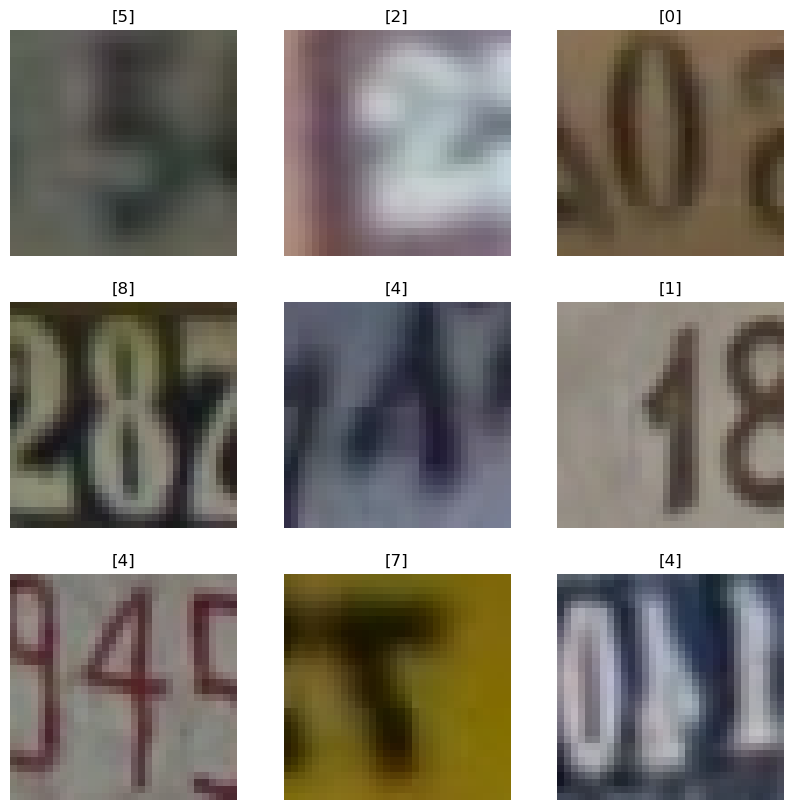

In [56]:
plot_sample_images_v2(flipped_images.astype('uint8'), flipped_labels)

## Normalization

Normalize the data to a common scale for more efficient training.

In [57]:
# Create the Normalization object
norm_layer = tf.keras.layers.Normalization(axis=-1)

# Fit the training data to calculate the mean and Variance
norm_layer.adapt(flipped_images)

In [58]:
print("Mean:", norm_layer.mean.numpy())  # Should output the computed mean
print("Variance:", norm_layer.variance.numpy())  # Should output the computed variance

Mean: [[[[109.86733 109.68329 113.76683]]]]
Variance: [[[[2511.18   2556.8303 2585.9927]]]]


In [59]:
# Normalize Data

with tf.device('/CPU:0'):
    X_train_normalized = norm_layer(flipped_images)
    X_val_normalized = norm_layer(X_val_reshaped)

In [ ]:
# normalise images

# flipped_images_norm = flipped_images.astype(np.float32) / 255
# X_val_reshaped_norm = X_val_reshaped / 255

In [412]:
# memmap_images = np.memmap('memmap_images.dat', dtype=np.float32,
#               mode='w+', shape=(598388, 32, 32, 3))

In [413]:
# memmap_images[:] = flipped_images[:]

In [414]:
# memmap_images.flush()

In [415]:
# new_memmap_images = np.memmap('memmap_images.dat', dtype='float32', mode='r', shape=(598388, 32, 32, 3))

In [421]:
# del memmap_images

In [423]:
# flipped_images_norm = new_memmap_images.astype(np.float32) / 255.

MemoryError: Unable to allocate 6.85 GiB for an array with shape (598388, 32, 32, 3) and data type float32

In [411]:
# batchsize = 100

# flipped_images_norm = np.zeros((598388, 32, 32, 3),dtype=np.uint8)

# for i in range(0, len(flipped_images), batchsize):
#     end = min(i + batchsize, len(flipped_images))
#     batch = flipped_images[i:i+end].astype(np.float32) / 255.0
#     flipped_images_norm[i:i+end] = batch 


MemoryError: Unable to allocate 495. MiB for an array with shape (42200, 32, 32, 3) and data type float32

In [410]:
# del flipped_images_norm, X_val_reshaped_norm

NameError: name 'X_val_reshaped_norm' is not defined

In [32]:
flipped_images_norm.shape

(598388, 32, 32, 3)

In [354]:
X_val_reshaped_norm[0]

array([[[0.38039216, 0.38431373, 0.39215687],
        [0.3529412 , 0.3529412 , 0.3764706 ],
        [0.31764707, 0.30588236, 0.3529412 ],
        ...,
        [0.5647059 , 0.5568628 , 0.70980394],
        [0.3529412 , 0.32156864, 0.5058824 ],
        [0.15294118, 0.09803922, 0.29803923]],

       [[0.31764707, 0.3137255 , 0.34117648],
        [0.29803923, 0.29803923, 0.32941177],
        [0.28627452, 0.28627452, 0.33333334],
        ...,
        [0.5647059 , 0.5568628 , 0.69803923],
        [0.34901962, 0.32156864, 0.48235294],
        [0.16862746, 0.11764706, 0.2901961 ]],

       [[0.2784314 , 0.27058825, 0.3137255 ],
        [0.2784314 , 0.2784314 , 0.3254902 ],
        [0.28235295, 0.2901961 , 0.34117648],
        ...,
        [0.5411765 , 0.5411765 , 0.6627451 ],
        [0.3529412 , 0.3254902 , 0.46666667],
        [0.2       , 0.15294118, 0.3019608 ]],

       ...,

       [[0.6666667 , 0.73333335, 0.7647059 ],
        [0.65882355, 0.7254902 , 0.7647059 ],
        [0.6431373 , 0

In [60]:
# Import module
from sklearn.preprocessing import OneHotEncoder

# Fit the OneHotEncoder ot the training labels
enc = OneHotEncoder().fit(flipped_labels)

# Transform the label values to a one-hot-encoding scheme
y_train_oh = enc.transform(flipped_labels).toarray()
y_val_oh = enc.transform(y_val_relabelled).toarray()

Below, I am computing the class weights of the training data. This will be used with the classification model to make sure when the accuracy is calculated the imbalance is taken into account.

In [61]:
# Reference: https://stackoverflow.com/questions/43481490/keras-class-weights-class-weight-for-one-hot-encoding
from sklearn.utils import class_weight


y_integers = np.argmax(y_train_oh, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)

d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 1.1992224137239968,
 1: 0.5763650899143719,
 2: 0.7062708763647093,
 3: 0.8714980629751536,
 4: 1.0408376963350785,
 5: 1.0011175801378571,
 6: 1.2810978612258879,
 7: 1.2213994121489222,
 8: 1.5033741175288295,
 9: 1.5536492275736726}

## Converting to Tensor

In [35]:
# with tf.device('/cpu:0'):
#     train_dataset = tf.data.Dataset.from_tensor_slices((flipped_images_norm, y_train_oh))
#     val_dataset = tf.data.Dataset.from_tensor_slices((X_val_reshaped_norm, y_val_oh))


In [62]:
with tf.device('/cpu:0'):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_normalized, y_train_oh))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val_normalized, y_val_oh))


In [63]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [166]:
# from keras import layers

# data_augmentation_hor_ver = tf.keras.Sequential([
#   layers.Rescaling(1./255),
#   layers.RandomFlip("horizontal_and_vertical"),
#   layers.RandomRotation(0.2),
# ])
# data_augmentation_hor = tf.keras.Sequential([
#   layers.Rescaling(1./255),
#   layers.RandomFlip("horizontal"),
#   layers.RandomRotation(0.2),
# ])

In [304]:
# tf.get_logger().setLevel('ERROR')

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   augmented_image = data_augmentation(X_train_reshaped[0:9])
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(augmented_image[1])
#   # plt.imshow(X_train_merge[0,:,:,:])
#   plt.axis("off")


## Model 1: Relu

In [64]:
import tensorflow as tf
import tensorflow_addons as tfa
from keras import activations

# Build the model
model_Relu_aug = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
  

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D((2, 2)), 
       

    tf.keras.layers.Flatten(),

    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  


    tf.keras.layers.Dense(10, activation='softmax')    # Output layer for 10 classes
])

# Compile the model
model_Relu_aug.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model_Relu_aug.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 dropout_4 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 dropout_5 (Dropout)         (None, 13, 13, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                  

In [65]:
# This callback will stop the training when there is no improvement in
# the loss for 5 consecutive epochs.

from keras import callbacks

callback = callbacks.EarlyStopping(monitor='val_loss', patience=20)


history_aug_relu = model_Relu_aug.fit(
    # X_train_normalized_lcn, y_train_oh,                 # Training data and labels
    train_dataset,                 # Training data and labels
    # validation_data=(X_val_normalized_lcn, y_val_oh),   # Validation data and labels
    validation_data=val_dataset,   # Validation data and labels
    # batch_size=128,                                 # Number of samples per batch
    epochs=100,                                      # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    callbacks=[callback],
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/100
4675/4675 [==============================] - 26s 6ms/step - loss: 0.4684 - accuracy: 0.8576 - val_loss: 0.3050 - val_accuracy: 0.9178
Epoch 2/100
4675/4675 [==============================] - 26s 6ms/step - loss: 0.2710 - accuracy: 0.9210 - val_loss: 0.2840 - val_accuracy: 0.9210
Epoch 3/100
4675/4675 [==============================] - 26s 6ms/step - loss: 0.2397 - accuracy: 0.9305 - val_loss: 0.2622 - val_accuracy: 0.9292
Epoch 4/100
4675/4675 [==============================] - 26s 6ms/step - loss: 0.2232 - accuracy: 0.9350 - val_loss: 0.2571 - val_accuracy: 0.9338
Epoch 5/100
4675/4675 [==============================] - 26s 5ms/step - loss: 0.2123 - accuracy: 0.9388 - val_loss: 0.2484 - val_accuracy: 0.9347
Epoch 6/100
4675/4675 [==============================] - 26s 5ms/step - loss: 0.2057 - accuracy: 0.9408 - val_loss: 0.2491 - val_accuracy: 0.9337
Epoch 7/100
4675/4675 [==============================] - 26s 6ms/step - loss: 0.1983 - accuracy: 0.9423 - val_loss: 0.2402 -

In [70]:
np.save('Relu_history_aug.npy',history_aug_relu.history)

In [71]:
model_Relu_aug.save("model_Relu_aug.keras")

## Model 2: Maxout

In [66]:
import tensorflow as tf
import tensorflow_addons as tfa

# Build the model
model_maxout_v1_aug = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
  

    tf.keras.layers.Conv2D(32, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=2),                   # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(64, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=2),                  # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(128, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=2),                   # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)), 
       

    tf.keras.layers.Flatten(),

    
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.5),    
    tfa.layers.Maxout(num_units=2),    

    tf.keras.layers.Dense(10, activation='softmax')    # Output layer for 10 classes
])

# Compile the model
model_maxout_v1_aug.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model_maxout_v1_aug.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 dropout_8 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 maxout (Maxout)             (None, 30, 30, 2)         0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 2)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        1216      
                                                                 
 dropout_9 (Dropout)         (None, 13, 13, 64)        0         
                                                      

In [67]:
# This callback will stop the training when there is no improvement in
# the loss for 5 consecutive epochs.

from keras import callbacks

callback = callbacks.EarlyStopping(monitor='val_loss', patience=20)


history_maxout_v1_aug = model_maxout_v1_aug.fit(
    # X_train_normalized_lcn, y_train_oh,                 # Training data and labels
    train_dataset,                 # Training data and labels
    # validation_data=(X_val_normalized_lcn, y_val_oh),   # Validation data and labels
    validation_data=(val_dataset),   # Validation data and labels
    # batch_size=128,                                 # Number of samples per batch
    epochs=100,                                     # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    callbacks=[callback],
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/100
4675/4675 [==============================] - 23s 5ms/step - loss: 1.9773 - accuracy: 0.3027 - val_loss: 2.2017 - val_accuracy: 0.1642
Epoch 2/100
4675/4675 [==============================] - 22s 5ms/step - loss: 1.7392 - accuracy: 0.3964 - val_loss: 2.3431 - val_accuracy: 0.1398
Epoch 3/100
4675/4675 [==============================] - 23s 5ms/step - loss: 1.6614 - accuracy: 0.4357 - val_loss: 2.3882 - val_accuracy: 0.1453
Epoch 4/100
4675/4675 [==============================] - 23s 5ms/step - loss: 1.6242 - accuracy: 0.4520 - val_loss: 2.4233 - val_accuracy: 0.1470
Epoch 5/100
4675/4675 [==============================] - 23s 5ms/step - loss: 1.6049 - accuracy: 0.4589 - val_loss: 2.4771 - val_accuracy: 0.1442
Epoch 6/100
4675/4675 [==============================] - 23s 5ms/step - loss: 1.5902 - accuracy: 0.4629 - val_loss: 2.4807 - val_accuracy: 0.1437
Epoch 7/100
4675/4675 [==============================] - 23s 5ms/step - loss: 1.5798 - accuracy: 0.4657 - val_loss: 2.5424 -

In [72]:
np.save('maxout_history_v1_aug.npy',history_maxout_v1_aug.history)

In [73]:
model_maxout_v1_aug.save("model_maxout_v1_aug.keras")

## Model 3: Maxout Version 2

In [68]:
import tensorflow as tf
import tensorflow_addons as tfa

# Build the model
model_maxout_v2_aug = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
  

    tf.keras.layers.Conv2D(32, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=16),                   # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(64, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=32),                  # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(128, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=64),                   # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)), 
       

    tf.keras.layers.Flatten(),

    
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.5),    
    tfa.layers.Maxout(num_units=64),    

    tf.keras.layers.Dense(10, activation='softmax')    # Output layer for 10 classes
])

# Compile the model
model_maxout_v2_aug.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model_maxout_v2_aug.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 dropout_12 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 maxout_4 (Maxout)           (None, 30, 30, 16)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        9280      
                                                                 
 dropout_13 (Dropout)        (None, 13, 13, 64)        0         
                                                      

In [69]:
# This callback will stop the training when there is no improvement in
# the loss for 5 consecutive epochs.

from keras import callbacks

callback = callbacks.EarlyStopping(monitor='val_loss', patience=10)


history_maxout_v2_aug = model_maxout_v2_aug.fit(
    # X_train_normalized, y_train_oh,                 # Training data and labels
    train_dataset,                 # Training data and labels
    # validation_data=(X_val_normalized, y_val_oh),   # Validation data and labels
    validation_data=(val_dataset),   # Validation data and labels
    # batch_size=128,                                 # Number of samples per batch
    epochs=100,                                     # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    callbacks=[callback],
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/100
4675/4675 [==============================] - 26s 5ms/step - loss: 0.5102 - accuracy: 0.8429 - val_loss: 0.3346 - val_accuracy: 0.9045
Epoch 2/100
4675/4675 [==============================] - 26s 6ms/step - loss: 0.2874 - accuracy: 0.9150 - val_loss: 0.3074 - val_accuracy: 0.9137
Epoch 3/100
4675/4675 [==============================] - 26s 6ms/step - loss: 0.2545 - accuracy: 0.9253 - val_loss: 0.2808 - val_accuracy: 0.9250
Epoch 4/100
4675/4675 [==============================] - 27s 6ms/step - loss: 0.2377 - accuracy: 0.9304 - val_loss: 0.2733 - val_accuracy: 0.9237
Epoch 5/100
4675/4675 [==============================] - 26s 6ms/step - loss: 0.2277 - accuracy: 0.9333 - val_loss: 0.2746 - val_accuracy: 0.9253
Epoch 6/100
4675/4675 [==============================] - 26s 6ms/step - loss: 0.2193 - accuracy: 0.9356 - val_loss: 0.2715 - val_accuracy: 0.9275
Epoch 7/100
4675/4675 [==============================] - 26s 5ms/step - loss: 0.2153 - accuracy: 0.9371 - val_loss: 0.2684 -

In [74]:
np.save('maxout_history_v2_aug.npy',history_maxout_v2_aug.history)

In [75]:
model_maxout_v2_aug.save("model_maxout_v2_aug.keras")

# Results

In [76]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df_Relu_aug = pd.DataFrame(history_aug_relu.history) 
hist_df_maxout_v1_aug = pd.DataFrame(history_maxout_v1_aug.history) 
hist_df_maxout_v2_aug = pd.DataFrame(history_maxout_v2_aug.history)

In [77]:
# Concatenate Datasets together and assign Dataset column with a label 

concat_history = pd.concat([hist_df_Relu_aug.assign(dataset='relu'), hist_df_maxout_v1_aug.assign(dataset='maxout_v1'), hist_df_maxout_v2_aug.assign(dataset='maxout_v2')])

In [78]:
# Function to the plot Training and Validation Scores

import matplotlib.pyplot as plt

def plot_accuracy_metric(dataframe, plotname):

    accuracy = dataframe["accuracy"]
    val_accuracy = dataframe["val_accuracy"]
    loss = dataframe["loss"]
    val_loss = dataframe["val_loss"]
    epochs = range(1, len(accuracy) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))


    # Subplot 1: Training and Validation Accuracy
    axes[0].plot(epochs, accuracy, "bo", label="Training accuracy")
    axes[0].plot(epochs, val_accuracy, "b", label="Validation accuracy")
    axes[0].set_title("Training and validation accuracy " + plotname)
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()
    # plt.figure()
    # Subplot 2: Training and Validation Loss
    axes[1].plot(epochs, loss, "bo", label="Training loss")
    axes[1].plot(epochs, val_loss, "b", label="Validation loss")
    axes[1].set_title("Training and validation loss " + plotname)
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

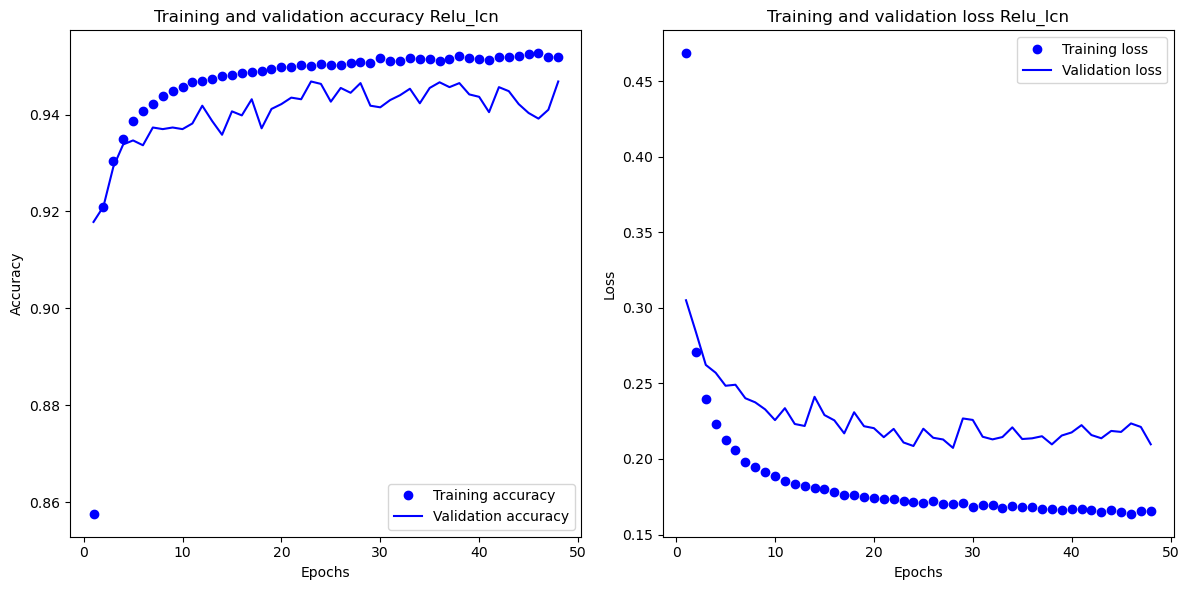

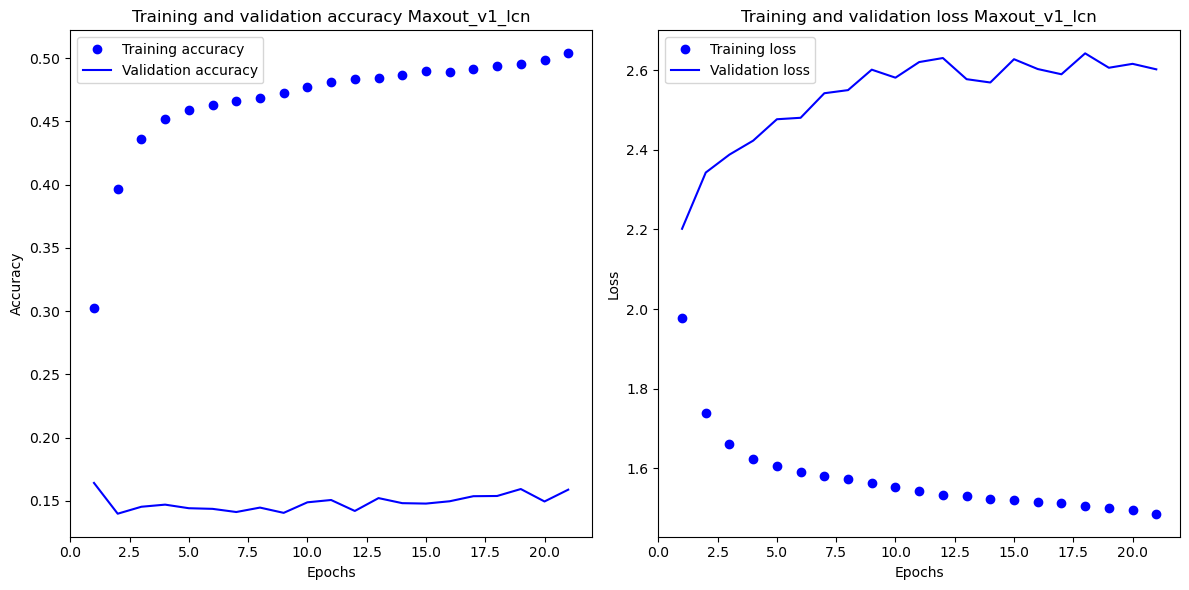

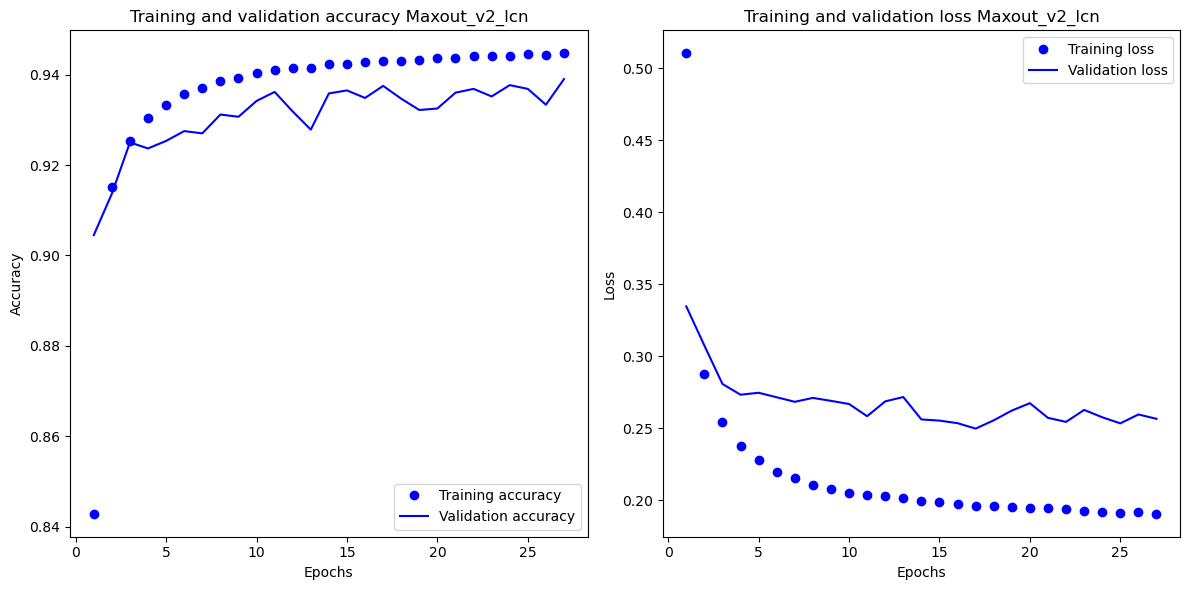

In [79]:
plot_accuracy_metric(hist_df_Relu_aug, 'Relu_lcn')
plot_accuracy_metric(hist_df_maxout_v1_aug, 'Maxout_v1_lcn')
plot_accuracy_metric(hist_df_maxout_v2_aug, 'Maxout_v2_lcn')

# Code Testing

In [422]:
import gc
import tensorflow as tf

# Clear memory
gc.collect()
tf.keras.backend.clear_session()

In [ ]:
def rescale_image(image):

    rescaled_image = (image - tf.reduce_min(
                            image )) / (tf.reduce_max(
                               image ) - tf.reduce_min(
                                    image ))
    
    return rescaled_image

In [ ]:
import tensorflow_io as tfio

image = X_train_reshaped[2, :, :, :]
# image = X_train_normalized[0, :, :, :]



# yuv = tfio.experimental.color.rgb_to_yuv(image)
image = image.astype('uint8')

print(image.shape, image.dtype, type(image))

plt.figure()
plt.imshow(image)
plt.axis('off')
plt.show()

In [43]:
for i in range(0,10):

        image = X_train_reshaped[i, :, :, :]

In [ ]:
# Converting to YUV Space and apply LCN to Y channel

import tensorflow_io as tfio

image = X_train_reshaped[2, :, :, :]
# image = X_train_normalized[2, :, :, :]


# Rescale Image for the RGB_YUV function
image = image / 255.

print('1', image.dtype, kernel.dtype,  image.min(), image.max())

# Convert to YUV Colour
yuv = tfio.experimental.color.rgb_to_yuv(image)



print('2',yuv.shape, yuv.dtype, type(yuv), yuv[:,:,0].dtype)

# Convert to numpy item assignment
yuv =  yuv.numpy()

print('3',yuv.shape, yuv.dtype, type(yuv))

# Apply Local contrast Normalisation on the Y channel
lcn_image = lcn(yuv[:,:,0], gaussian_matrix)

# Assign Y_LCN back to Image YUV matrix
yuv[:,:,0] = lcn_image.astype('float32')


print('4',lcn_image.shape, lcn_image.dtype, type(lcn_image))
print('5',yuv.shape, yuv.dtype, type(yuv), yuv[:,:,0].dtype)

plt.figure()
plt.imshow(yuv)
plt.axis('off')
plt.show()

lcn_image


In [ ]:
# Apply Global contrast Normalization to all channels

yuv_2 = yuv

print('3',yuv_2.shape, yuv_2.dtype, type(yuv_2))

y = global_contrast_normalization(yuv_2[:,:,0],1, 1, 0.000000001 )
# y = rescale_image(y)
u = global_contrast_normalization(yuv_2[:,:,1],1, 1, 0.000000001 )
# u = rescale_image(u)
v = global_contrast_normalization(yuv_2[:,:,2],0.1, 1, 0.000000001 )
# v = rescale_image(v)

yuv_2[:,:,0], yuv_2[:,:,1], yuv_2[:,:,2] = y, u , v

plt.figure()
plt.imshow(yuv_2)
plt.axis('off')
plt.show()



In [ ]:
# Converting back to RGB to display

# rgb_2 = tfio.experimental.color.yuv_to_rgb(X_lcn_y[1,:,:,:])
# rgb_2 = tfio.experimental.color.yuv_to_rgb(X_train_reshaped[0,:,:,:])
rgb_2  =  rgb_2 .numpy()
r = rescale_image(rgb_2[:,:,0])
g = rescale_image(rgb_2[:,:,1])
b = rescale_image(rgb_2[:,:,2])

rgb_2[:,:,0], rgb_2[:,:,1], rgb_2[:,:,2] = r, g, b


plt.figure(figsize=(1, 1))
# plt.figure()
plt.imshow(X_lcn_y[1,:,:,:])
plt.axis('off')
plt.show()


In [ ]:
X_train_merge[:,:,:,0].shape

In [ ]:
import tensorflow_io as tfio

image = tf.cast(X_train_merge[:,:,:,2], tf.float32) / 255.0
# image = X_train_normalized[0, :, :, :]



print(tf.reduce_min(image), tf.reduce_max(image))
print(image.shape)


yuv = tfio.experimental.color.rgb_to_yuv(image)

print(yuv.shape, yuv.dtype)


plt.figure()
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:


plt.figure()
plt.imshow(X_train_reshaped[0, :, :, :].astype('int32'))
plt.axis('off')
plt.show()